In [1]:
library(assertthat)
library(dplyr)
library(purrr)
library(ggraph)
library(ggmap)
library(ggplot2)
library(igraph)
library(rjson)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.


Attaching package: 'igraph'


The following objects are masked from 'package:purrr':

    compose, simplify


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




## Read in Traffic Data for 4th Quarter Winter, December

In [2]:
santa_filename <- "los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
filepath <- "santa_data"
santa_df <- read.csv(file.path(filepath, santa_filename),stringsAsFactors=FALSE,header=TRUE)

In [ ]:
geo_filename <- "los_angeles_censustracts.json"
geodata_json <- fromJSON(file=file.path(filepath, geo_filename))

In [ ]:
edge_list <- santa_df[santa_df$month==12,c("sourceid","dstid","mean_travel_time")]
names(edge_list) <- c("src","dst","weight")

In [ ]:
location_graph <- graph_from_data_frame(edge_list,directed=FALSE)

## Get the Addresses and Longitude and Latitude

In [ ]:
V(location_graph)$centroid_x <- NA
V(location_graph)$centroid_y <- NA
V(location_graph)$location_id <- NA

In [ ]:
key <- names(read.delim('C:/Users/lpott/Desktop/geolocation_key.txt'))
register_google(key = key)

In [ ]:
for (feature in geodata_json$features){
    centroid <- colMeans(matrix(unlist(feature$geometry$coordinates),ncol=2,byrow=TRUE))
    vertex_id <- feature$properties$MOVEMENT_ID

    if (!(vertex_id %in% V(location_graph)$name)){
        next
    }
    #set.vertex.attribute(location_graph,'centroid',vertex_id,centroid)
    V(location_graph)[vertex_id]$location_id <- revgeocode(c(centroid[1],centroid[2]),output='address')
    V(location_graph)[vertex_id]$centroid_x <- centroid[1]
    V(location_graph)[vertex_id]$centroid_y <- centroid[2]
}

In [2]:
#save.image(file="open_ended.RData")
load(file="open_ended.RData")

## Simplify the graph by removing isolated nodes and aggregating multiple edge

In [3]:
los_angeles_nodes <- V(location_graph)$name[sapply( V(location_graph)$location_id,function (x){grepl( "Los Angeles", x, fixed = TRUE)})]

In [4]:
los_angeles_graph <- induced.subgraph(location_graph,los_angeles_nodes)

In [5]:
sprintf("Los Angeles Nodes %d Edge %d",vcount(los_angeles_graph),ecount(los_angeles_graph))

[1] "Los Angeles Nodes 633 Edge 296254"

In [6]:
cl<-clusters(los_angeles_graph)
largest_g<-induced.subgraph(los_angeles_graph, which(cl$membership == which.max(cl$csize)))

In [7]:
location_graph_simplified <- simplify(largest_g, edge.attr.comb="mean",remove.loops=TRUE)

In [8]:
sprintf("# Nodes: %d , # Edges: %d",vcount(location_graph_simplified),ecount(location_graph_simplified))

[1] "# Nodes: 633 , # Edges: 157232"

## Convert the graph to a directed graph

In [9]:
location_graph_directed <- as.directed(location_graph_simplified,'mutual')

In [10]:
sprintf("# Nodes: %d , # Edges: %d",vcount(location_graph_directed),ecount(location_graph_directed))

[1] "# Nodes: 633 , # Edges: 314464"

## Initialize Graph for Linear Threshold Model

In [11]:
library(stringr)

In [12]:
# invert the edge weight, as we want far distance (high weight) to have little influence
E(location_graph_directed)$weight <- 1/E(location_graph_directed)$weight

# normalize the edge weights, such that the sum of all the in edges is 1
E(location_graph_directed)$weight <- E(location_graph_directed)$weight / strength(location_graph_directed, mode="in")[get.edgelist(location_graph_directed)[,2]]

### linear threshold model algorithm

In [13]:
trials <- 1000
time_steps <- 75
active_set_sizes <- c(5,10,15,20,25,30,45,50)
results_list <- vector(mode = "list", length = length(active_set_sizes))
names(results_list) <- as.character(active_set_sizes)

In [ ]:
for (active_set_size in c(5,10,15,20,25,30,45,50)){
    ptm <- proc.time()

#     print(sprintf("===================Active Set Size %d=================",active_set_size))
#     flush.console()
    # select a random amount of nodes for target size to activate... based on heuristics ...
    
    n_initial_nodes <- active_set_size
    start_nodes <- names(sort(degree(location_graph_directed),decreasing=TRUE)[1:n_initial_nodes])
    active_counts <- matrix(nrow=trials,ncol=time_steps)
    
    for (T in seq_len(trials)){
#         ptm <- proc.time()
        # each node has a latent threshold to become active from influence of neighbors
        V(location_graph_directed)$theta <- runif(vcount(location_graph_directed))
        thresholds <- V(location_graph_directed)$theta

        # change the active status to ON!, and initialize first active nodes!
        V(location_graph_directed)$active <- 0
        V(location_graph_directed)[start_nodes]$active <- 1

        # get directed weighted adjacency matrix
        adjacency_matrix <- get.adjacency(location_graph_directed,attr='weight')

        # apply algorithm for T time steps
        for (t in seq_len(time_steps)){
    #         print(sprintf("===================Time Step %d=================",t))

    #         ptm <- proc.time()

            sweeped_data <- sweep(adjacency_matrix,MARGIN=2,V(location_graph_directed)$active,'*')
            new_active <- as.integer(Matrix::rowSums(sweeped_data) > thresholds) |  V(location_graph_directed)$active
            V(location_graph_directed)$active <- new_active


    #         print_string <- sprintf("elapsed time %.4f",(proc.time() - ptm)[1])
    #         print(print_string)
    #         flush.console()
            active_counts[T,t] <- sum(new_active)
        }
#         print(sprintf("===================Trial %d ---- Time %.5f=================",T,(proc.time() - ptm)[1]))
#         flush.console()
    }
    print(sprintf("===================Active Set Size %d ---- Time %.5f=================",active_set_size,(proc.time() - ptm)[1]))
    flush.console()
    results_list[[as.character(active_set_size)]] <- active_counts
}

In [ ]:
#save(results_list,file="influence_degree.RData")

In [14]:
load(file="influence_degree.RData")

In [15]:
final_results <- unlist(lapply(results_list,function (x){colMeans(x)[time_steps]}))

png 
  3

png 
  2

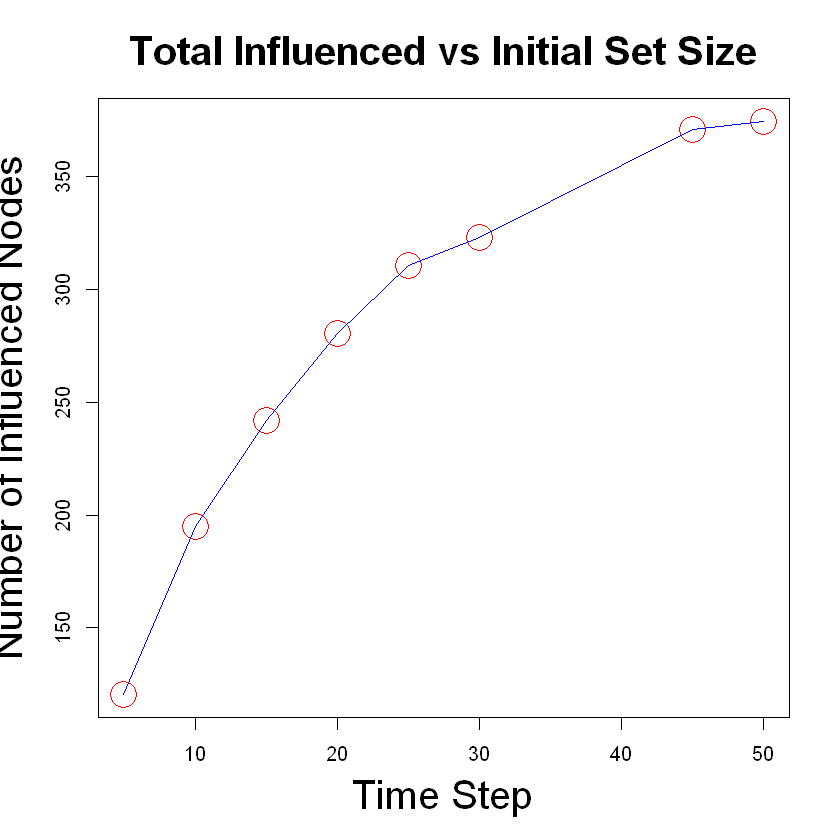

In [16]:
plot(active_set_sizes,final_results,
    col='red',
            main=sprintf("Total Influenced vs Initial Set Size"),
            xlab="Time Step",
            ylab="Number of Influenced Nodes",
    cex.main=2,
    cex.lab=2,
    cex=3)
lines(active_set_sizes,final_results,col='blue')

filename <- paste('images\\open_end_',"total_influence",'.png')
dev.copy(png,filename)
dev.off()

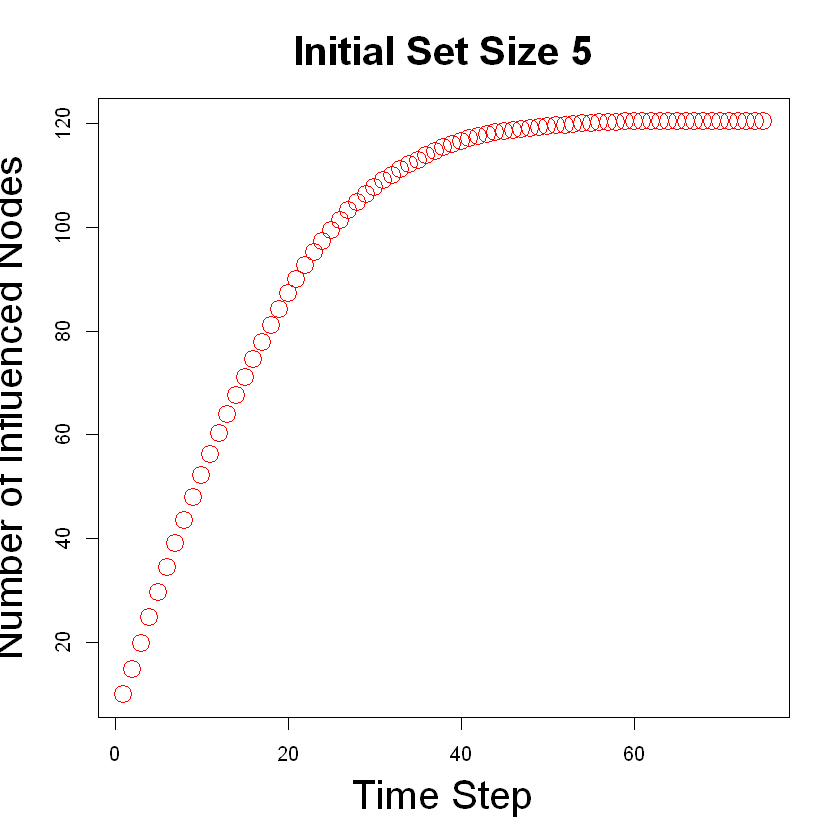

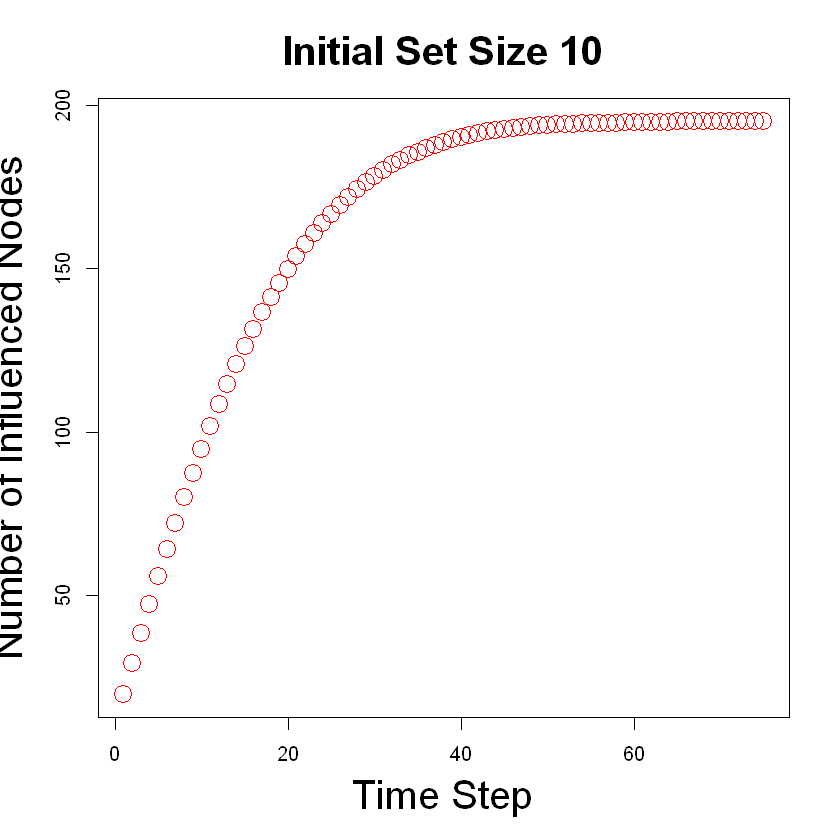

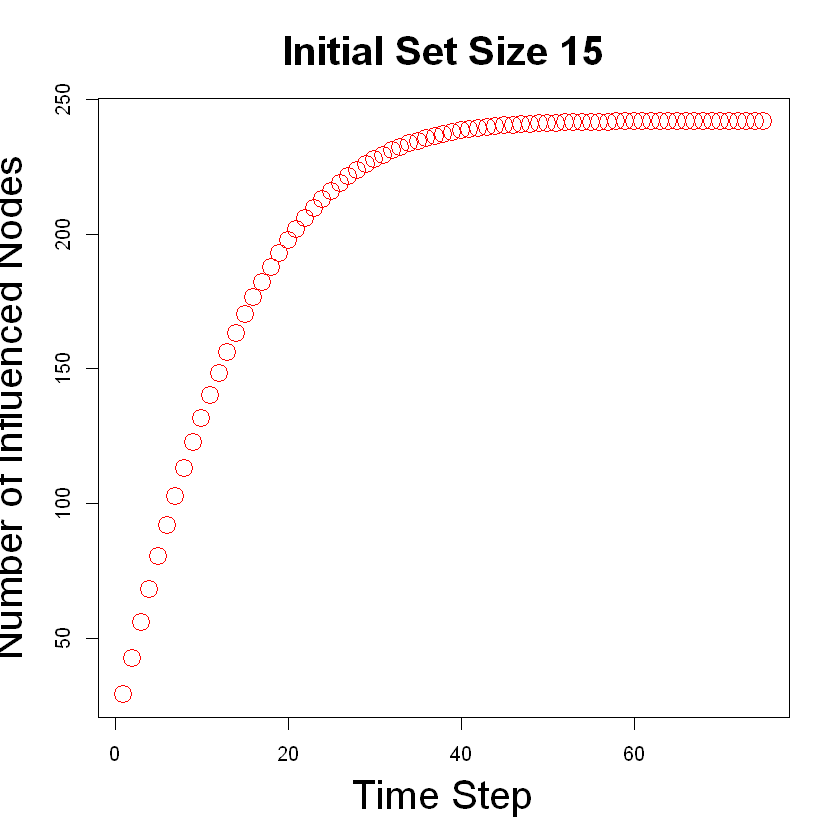

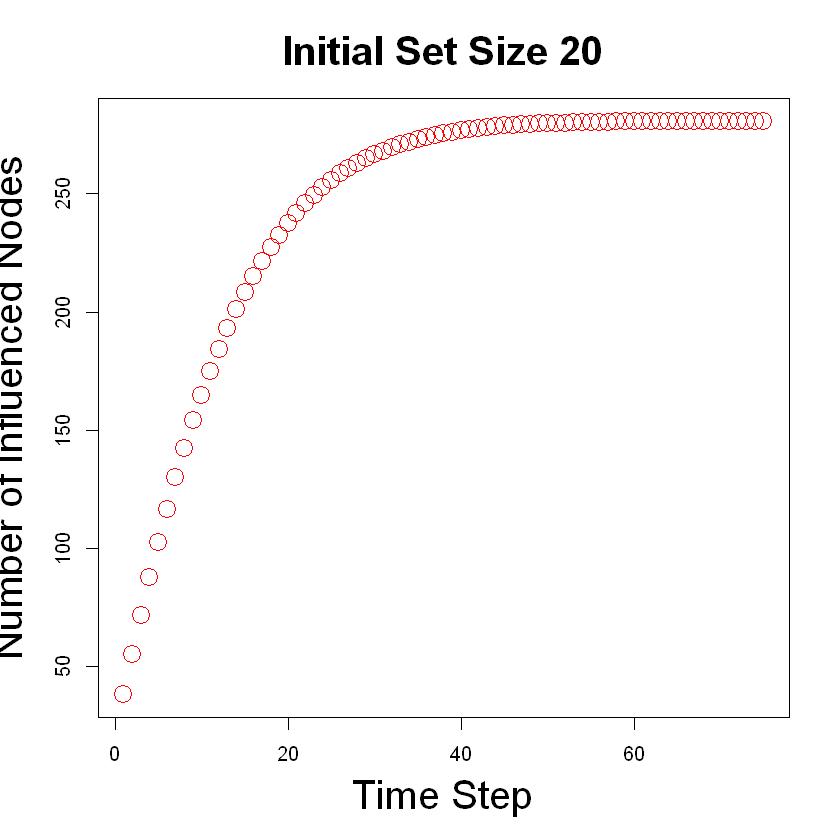

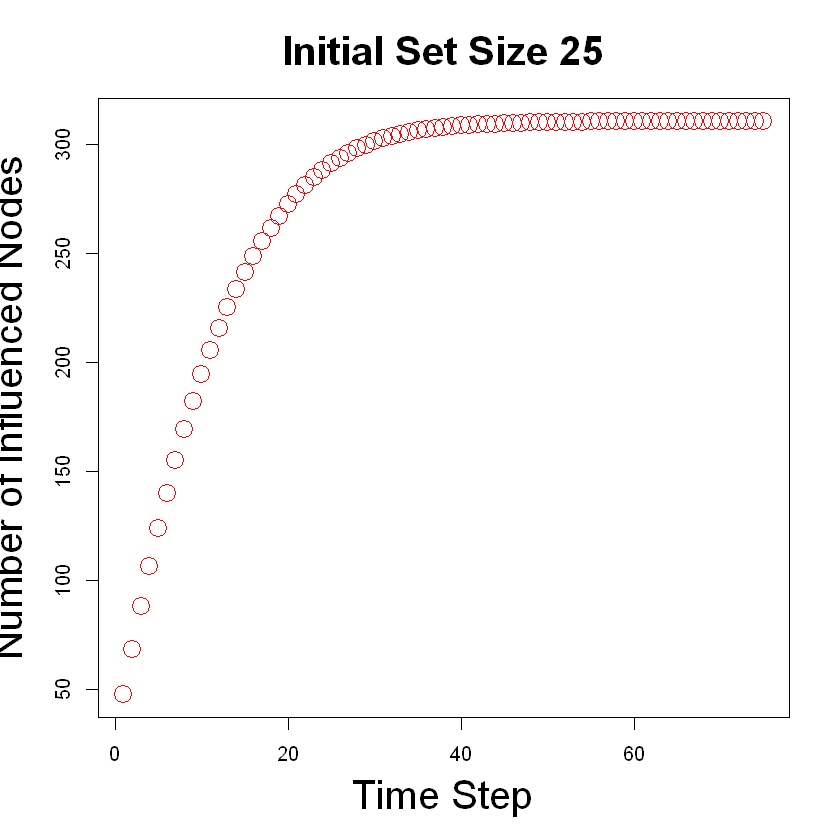

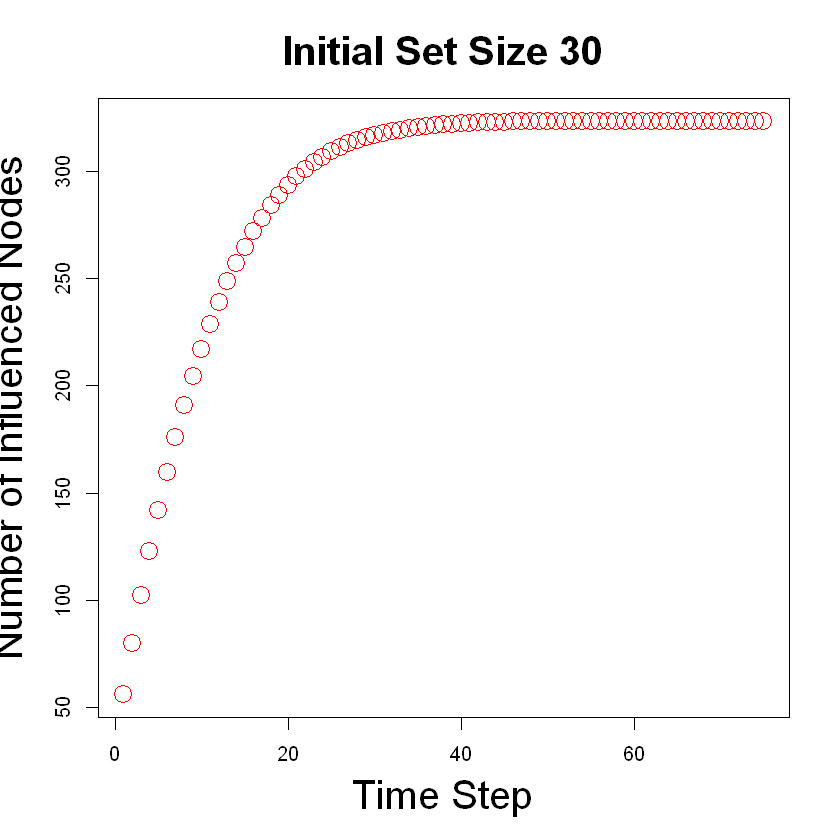

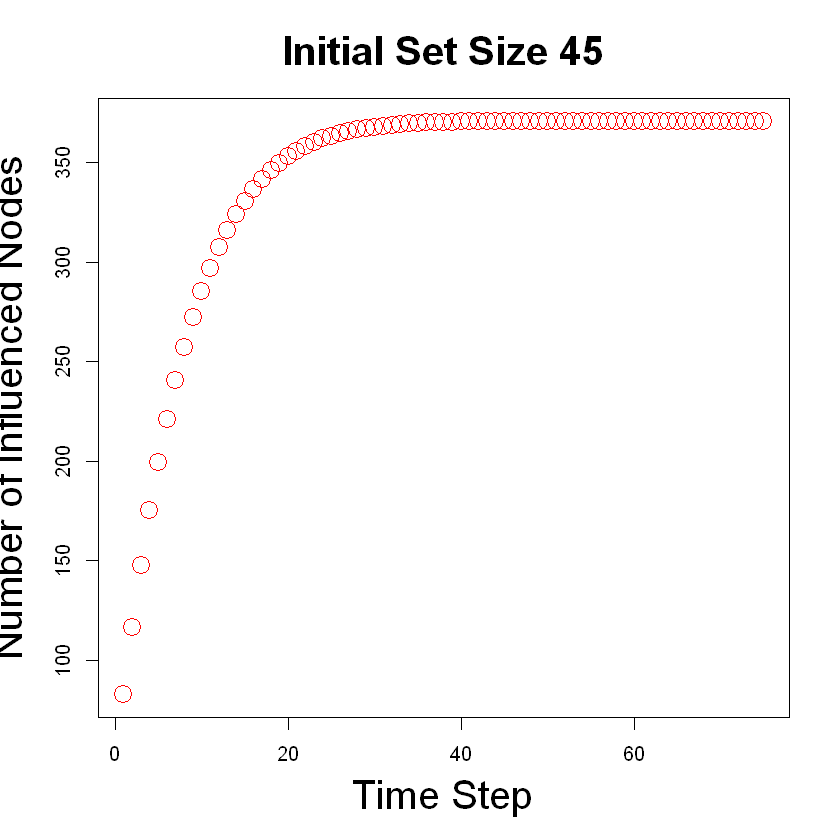

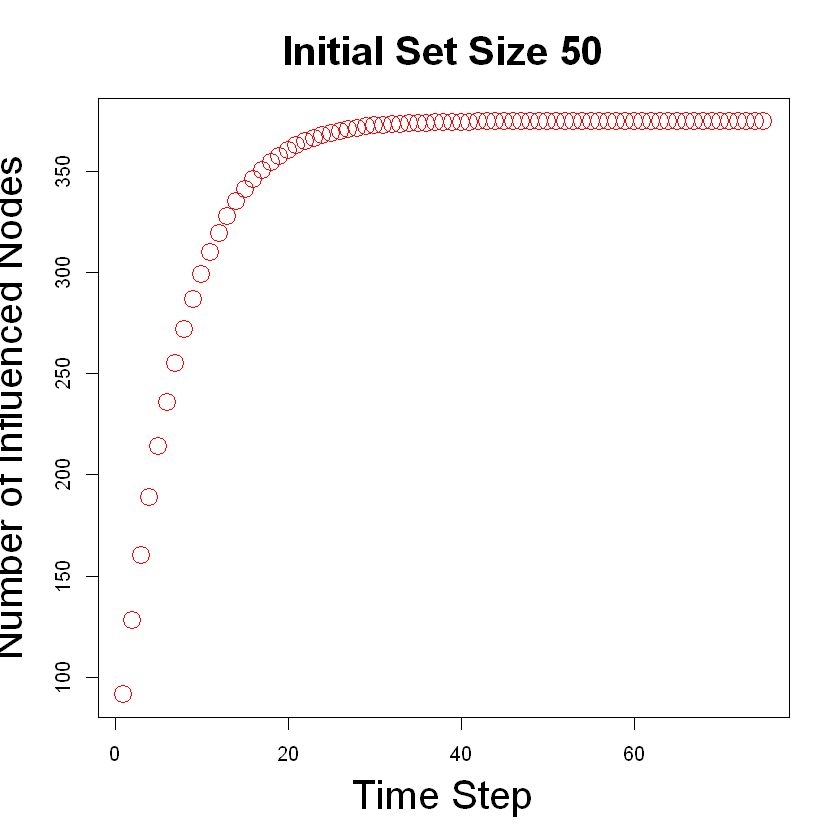

In [17]:
for (active_set_ in as.character(active_set_sizes)){
    plot(colMeans(results_list[[active_set_]]),
            col='red',
            main=sprintf("Initial Set Size %s",active_set_),
            xlab="Time Step",
            ylab="Number of Influenced Nodes",
             cex.main=2,
    cex.lab=2,
         cex=2
    )
    filename <- paste('images\\open_end_',active_set_,'.png')
    dev.copy(png,filename)
    dev.off()
}

## Visualize Spread

In [18]:
vertex_df <- as.data.frame(list(
      V(location_graph_directed)$name,
      V(location_graph_directed)$centroid_x,
     V(location_graph_directed)$centroid_y,
     V(location_graph_directed)$location_id,
    degree(location_graph_directed)
     ))
names(vertex_df) <- c('id','lon','lat','name','weight')

In [22]:
edge_df <- as.data.frame(
                        list(
                        get.edgelist(as.undirected(location_graph_directed)),
                        E(as.undirected(location_graph_directed))$weight,
                        1
                        )
                        )
names(edge_df) <- c("from","to","weight","category")

edges_for_plot <- edge_df %>%
  inner_join(vertex_df %>% select(id, lon, lat), by = c('from' = 'id')) %>%
  rename(x = lon, y = lat) %>%
  inner_join(vertex_df %>% select(id, lon, lat), by = c('to' = 'id')) %>%
  rename(xend = lon, yend = lat)

assert_that(nrow(edges_for_plot) == nrow(edge_df))

[1] TRUE

In [25]:
trials <- 1
time_steps <- 75
active_set_sizes <- 10

In [26]:
n_initial_nodes <- active_set_sizes
start_nodes <- names(sort(degree(location_graph_directed),decreasing=TRUE)[1:n_initial_nodes])
active_counts <- matrix(nrow=trials,ncol=time_steps)

In [ ]:
qmplot(lon,lat,data=vertex_df,
       colour = I('red'), 
       size = I(4), 
       darken = .3,
      main="Long Beach Zoom In") + theme(plot.title = element_text(size=22)) +

geom_segment(data=edges_for_plot,
             aes(x=x,y=y,xend=xend,yend=yend),
               size=1,
             alpha=0.75)# + 

#geom_point(data=vertex_df[start_nodes,],aes(x=lon,y=lat),colour='green',size=4) 

Using zoom = 11...

Source : http://tile.stamen.com/terrain/11/349/815.png

Source : http://tile.stamen.com/terrain/11/350/815.png

Source : http://tile.stamen.com/terrain/11/351/815.png

Source : http://tile.stamen.com/terrain/11/352/815.png

Source : http://tile.stamen.com/terrain/11/349/816.png

Source : http://tile.stamen.com/terrain/11/350/816.png

Source : http://tile.stamen.com/terrain/11/351/816.png

Source : http://tile.stamen.com/terrain/11/352/816.png

Source : http://tile.stamen.com/terrain/11/349/817.png

Source : http://tile.stamen.com/terrain/11/350/817.png

Source : http://tile.stamen.com/terrain/11/351/817.png

Source : http://tile.stamen.com/terrain/11/352/817.png

Source : http://tile.stamen.com/terrain/11/349/818.png

Source : http://tile.stamen.com/terrain/11/350/818.png

Source : http://tile.stamen.com/terrain/11/351/818.png

Source : http://tile.stamen.com/terrain/11/352/818.png



In [ ]:
for (T in seq_len(trials)){
#         ptm <- proc.time()
    # each node has a latent threshold to become active from influence of neighbors
    V(location_graph_directed)$theta <- runif(vcount(location_graph_directed))
    thresholds <- V(location_graph_directed)$theta

    # change the active status to ON!, and initialize first active nodes!
    V(location_graph_directed)$active <- 0
    V(location_graph_directed)[start_nodes]$active <- 1

    # get directed weighted adjacency matrix
    adjacency_matrix <- get.adjacency(location_graph_directed,attr='weight')

    # apply algorithm for T time steps
    for (t in seq_len(time_steps)){
#         print(sprintf("===================Time Step %d=================",t))

#         ptm <- proc.time()

        sweeped_data <- sweep(adjacency_matrix,MARGIN=2,V(location_graph_directed)$active,'*')
        new_active <- as.integer(Matrix::rowSums(sweeped_data) > thresholds) |  V(location_graph_directed)$active
        V(location_graph_directed)$active <- new_active


#         print_string <- sprintf("elapsed time %.4f",(proc.time() - ptm)[1])
#         print(print_string)
#         flush.console()
        active_counts[T,t] <- sum(new_active)
    }
    qmplot(lon,lat,data=vertex_df,
       colour = I('red'), 
       size = I(4), 
       darken = .3,
    ylim=c(x2-0.03,x2+0.03),
    xlim = c(y2-0.03,y2+.03),
      main="Long Beach Zoom In") + theme(plot.title = element_text(size=22)) +

    geom_segment(data=edges_for_triangulate,
                 aes(x=x,y=y,xend=xend,yend=yend),
                   size=1,
                 alpha=0.75) + 

    geom_point(data=vertex_df[long_beach_node,],aes(x=lon,y=lat),colour='green',size=4) 
}